## yfactor_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、12 素子 の IV カーブ plot が表示されます
    - 100 GHz 帯 ( SSB ) 素子 : 8 個
    - 200 GHz 帯 ( 2SB ) 素子 : 4 個

### モジュールを import します。

In [43]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib

import warnings
warnings.filterwarnings('ignore')
if sys.argv[1] == 'xxx': pass
else: 
    %matplotlib inline

matplotlib.use('Agg')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import necstdb

### database を読み込みます。

In [55]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

data_path = '/media/usbdisk/data/{mode}/{date}.necstdb/'.format(**locals())

db = necstdb.opendb(data_path)

### beam ごとに、パラメーターをディクショナリに格納します。
- パラメーター
  - SIS Voltage ( mV )
  - SIS Current ( uA )

In [56]:
beam_list = [
    '2l', '2r', '3l', '3r',
    '4l', '4r', '5l', '5r', 
    '1lu', '1ll', '1ru', '1rl'
]
vol_topic_list = ['sis_vol_{}'.format(vol) for vol in beam_list]
cur_topic_list = ['sis_cur_{}'.format(cur) for cur in beam_list]

In [57]:
vol_df, cur_df = {}, {}
for vol_topic, cur_topic in zip(vol_topic_list, cur_topic_list):
    vol_df[vol_topic] = db.open_table(vol_topic).read(astype='pandas')
    vol_df[vol_topic]['timestamp'] = pd.to_datetime(vol_df[vol_topic]['timestamp'], unit='s')
    vol_df[vol_topic] = vol_df[vol_topic].set_index('timestamp').sort_index()    
    cur_df[cur_topic] = db.open_table(cur_topic).read(astype='pandas')
    cur_df[cur_topic]['timestamp'] = pd.to_datetime(cur_df[cur_topic]['timestamp'], unit='s')
    cur_df[cur_topic] = cur_df[cur_topic].set_index('timestamp').sort_index() 

In [58]:
dataset = {}
resample_time = '0.04S'
for beam in beam_list:
     dataset[beam] = pd.concat(
         [
             vol_df['sis_vol_{}'.format(beam)].rename(columns={'data': 'sis_vol_{}'.format(beam)}) \
             .astype(float).resample(resample_time).mean().round({'sis_vol_{}'.format(beam): 2}),
             cur_df['sis_cur_{}'.format(beam)].rename(columns={'data': 'sis_cur_{}'.format(beam)}) \
             .astype(float).resample(resample_time).mean(),
             ],
         axis=1
         ).set_index('sis_vol_{}'.format(beam)).groupby(level=0).mean()

### IV カーブ を plot します。

info : Saved image. ( hot_cold.png )


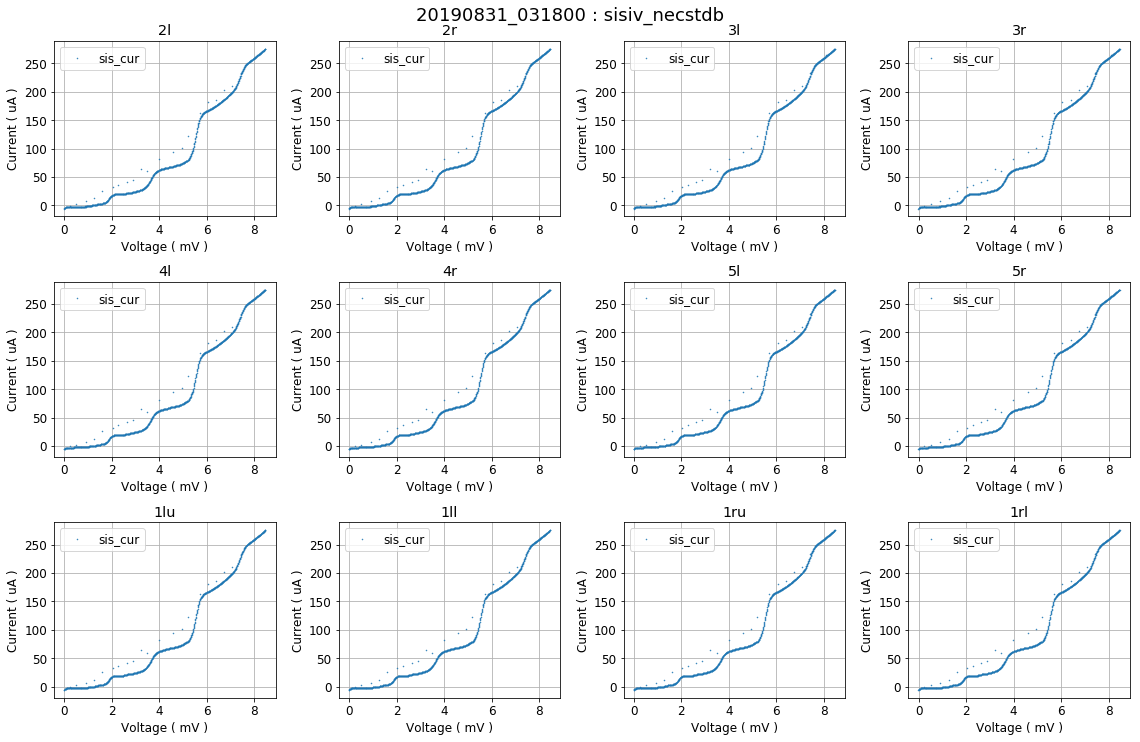

In [59]:
ncol = 4
nrow = 3
nax = ncol * nrow

figsize = (ncol * 4, nrow * 3.5)

fig = matplotlib.pyplot.figure(figsize=figsize)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, key, data in zip(ax, dataset.keys(), dataset.values()):
    _ax.plot(data['sis_cur_{}'.format(key)], '.', markersize=1, label='sis_cur')
    _ax.set_xlabel('Voltage ( mV )')
    _ax.set_ylabel('Current ( uA )')
    _ax.set_title(key)
    _ax.grid()
    _ax.legend()    
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./hot_cold.png')
print('info : Saved image. ( hot_cold.png )')